# 6.1.매개변수 갱신

In [1]:
import numpy as np

class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

- SGD는 비등방성anisotropy 함수(방향에 따라 성질, 여기서는 기울기가 달라지는 함수)에서는 탐색 경로가 비효율적이다.
- 이러한 단점을 개선해주는 모멘텀, AdaGrad, Adam이라는 방법을 소개한다.

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]


In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}

            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
            # 1e-7 : h[key]에 0이 있는 경우 0으로 나누는 것을 방지. 이 값도 설정 가능

### Adam
- 모멘텀과 AdaGrad의 두 기법을 융합한 기법. 2015년에 제안되었음.
- 또 하이퍼파라미터의 '편향 보정'이 진행됨

# 6.2.가중치의 초깃값

In [4]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 활성화값을 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

- 표준편차가 1인 정규분포로 초기화했을 때 0과 1에 치우쳐 분포되어 있음.
- 기울기 소실이 발생한다.

- 표준편차를 0.01로 한 정규분포의 경우 0.5부근에 집중됨.
- 표현력 제한한다는 관점에서 문제가 됨.

- Xavier 초깃값 : 초깃값의 표준편차가 1/√n이 되도록 설정
- n : 앞 층의 노드 수
- 층이 깊어지면서 형태가 일그러지지만 앞에 방식과 비교해 넓게 분포됨을 알 수 있다.


ReLU는 음수가 0이므로 더 넓게 퍼트리기 위해 계수가 2배여야 한다고 해석할 수 있다.

ReLU를 사용한 경우, 0.01, xavier, He를 사용했을 때
0.01은 활성화 값이 아주 작아 기울기 소실이 발생하며
Xavier는 층이 깊어질 수록 치우침이 커진다.
He는 모든 층에서 균일하게 분포되었다.


# 6.3.배치 정규화

- 배치 정규화 : 앞 절에서는 가중치의 초깃값을 조절해 활성화값을 퍼트렸다.
- 각 층이 활성화 값을 적당히 퍼트리는 것을 강제하도록 하는 것을 배치 정규화Batch Normalization
이라고 한다.

# 6.4.바른 학습을 위해

In [8]:
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD
from common.util import shuffle_dataset

epoch:0, train acc:0.08, test acc:0.0882
epoch:1, train acc:0.07666666666666666, test acc:0.087
epoch:2, train acc:0.08666666666666667, test acc:0.0931
epoch:3, train acc:0.09, test acc:0.0984
epoch:4, train acc:0.11666666666666667, test acc:0.1193
epoch:5, train acc:0.17666666666666667, test acc:0.151
epoch:6, train acc:0.20333333333333334, test acc:0.1833
epoch:7, train acc:0.24333333333333335, test acc:0.2048
epoch:8, train acc:0.31, test acc:0.2402
epoch:9, train acc:0.3566666666666667, test acc:0.2661
epoch:10, train acc:0.38666666666666666, test acc:0.2946
epoch:11, train acc:0.42, test acc:0.3174
epoch:12, train acc:0.4866666666666667, test acc:0.3386
epoch:13, train acc:0.5133333333333333, test acc:0.3658
epoch:14, train acc:0.5266666666666666, test acc:0.3835
epoch:15, train acc:0.5266666666666666, test acc:0.398
epoch:16, train acc:0.5266666666666666, test acc:0.4087
epoch:17, train acc:0.5633333333333334, test acc:0.4389
epoch:18, train acc:0.5766666666666667, test acc:0.459

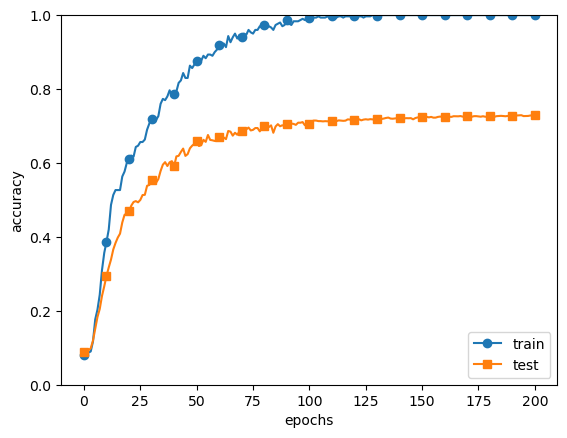

In [10]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
weight_decay_lambda = 0  # weight decay를 사용하지 않을 경우
# weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784,
                        hidden_size_list=[100, 100, 100, 100, 100, 100],
                        output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)  # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc)
              + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 가중치 감소
- W : 가중치
- L2 노름에 따른 가중치 감소 = 1/2 * λ * W²
- λ(람다) : 정규화의 세기를 조절하는 하이퍼파라미터. 크게 설정할수록 큰 가중치에 대한 패널티가 커짐
이 코드에서는 0.1로 적용함.

결과는 훈련 데이터와 시험 데이터의 정확도 차이가 줄어들고 훈련 데이터의 정확도도 100%에
도달하지 못했음.

In [1]:
class Dropout:
    """
    순전파 때마다 mask에 삭제할 뉴런을 False로 표시한다. mask는 x와 같은 형상의 무작위 배열을
    생성하고 그 값이 dropout_ratio보다 큰 원소만 True로 설정한다.
    역전파 때의 동작은 ReLU와 같다.
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask
